In [1]:
import tensorflow as tf

In [2]:
import os
for dirname, _, filenames in os.walk('input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import tensorflow as tf


In [3]:
from tensorflow.keras import layers

In [4]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.calibration import CalibratedClassifierCV
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
from scipy.stats import boxcox, median_abs_deviation
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.feature_selection import VarianceThreshold, mutual_info_classif, RFECV, SelectKBest , f_classif
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from scipy import stats
import statsmodels.api as sm
import pylab as py
from scipy.stats import norm
from sklearn.metrics import precision_recall_curve, auc, roc_curve


In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
tf.__version__

'2.12.0'

In [7]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_sub = pd.read_csv('sample_submission.csv')

In [8]:
train.shape, test.shape

((1677, 35), (1119, 34))

In [9]:
train.head()

,id,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
0,0,36,Travel_Frequently,599,Research & Development,24,3,Medical,1,4,...,80,1,10,2,3,10,0,7,8,0
1,1,35,Travel_Rarely,921,Sales,8,3,Other,1,1,...,80,1,4,3,3,4,2,0,3,0
2,2,32,Travel_Rarely,718,Sales,26,3,Marketing,1,3,...,80,2,4,3,3,3,2,1,2,0
3,3,38,Travel_Rarely,1488,Research & Development,2,3,Medical,1,3,...,80,0,15,1,1,6,0,0,2,0
4,4,50,Travel_Rarely,1017,Research & Development,5,4,Medical,1,2,...,80,0,31,0,3,31,14,4,10,1


## Data exploration

In [10]:
print(train.dtypes)

id                           int64
Age                          int64
BusinessTravel              object
DailyRate                    int64
Department                  object
DistanceFromHome             int64
Education                    int64
EducationField              object
EmployeeCount                int64
EnvironmentSatisfaction      int64
Gender                      object
HourlyRate                   int64
JobInvolvement               int64
JobLevel                     int64
JobRole                     object
JobSatisfaction              int64
MaritalStatus               object
MonthlyIncome                int64
MonthlyRate                  int64
NumCompaniesWorked           int64
Over18                      object
OverTime                    object
PercentSalaryHike            int64
PerformanceRating            int64
RelationshipSatisfaction     int64
StandardHours                int64
StockOptionLevel             int64
TotalWorkingYears            int64
TrainingTimesLastYea

In [11]:
other_cols = train.select_dtypes(exclude=['int64']).columns.tolist()
print("Other columns:")
for col in other_cols:
    print(col)

Other columns:
BusinessTravel
Department
EducationField
Gender
JobRole
MaritalStatus
Over18
OverTime


In [12]:
print(train.nunique())

id                          1677
Age                           43
BusinessTravel                 3
DailyRate                    625
Department                     3
DistanceFromHome              29
Education                      6
EducationField                 6
EmployeeCount                  1
EnvironmentSatisfaction        4
Gender                         2
HourlyRate                    71
JobInvolvement                 4
JobLevel                       6
JobRole                        9
JobSatisfaction                4
MaritalStatus                  3
MonthlyIncome                895
MonthlyRate                  903
NumCompaniesWorked            10
Over18                         1
OverTime                       2
PercentSalaryHike             15
PerformanceRating              2
RelationshipSatisfaction       4
StandardHours                  1
StockOptionLevel               4
TotalWorkingYears             41
TrainingTimesLastYear          7
WorkLifeBalance                4
YearsAtCom

In [13]:
print(train.describe())

                id          Age    DailyRate  DistanceFromHome    Education  \
count  1677.000000  1677.000000  1677.000000       1677.000000  1677.000000   
mean    838.000000    36.036971   892.749553          8.683959     2.937984   
std     484.252517     8.507112   374.496259          7.826143     1.039078   
min       0.000000    18.000000   107.000000          1.000000     1.000000   
25%     419.000000    30.000000   589.000000          2.000000     2.000000   
50%     838.000000    35.000000   890.000000          7.000000     3.000000   
75%    1257.000000    41.000000  1223.000000         12.000000     4.000000   
max    1676.000000    60.000000  3921.000000         29.000000    15.000000   

       EmployeeCount  EnvironmentSatisfaction   HourlyRate  JobInvolvement  \
count         1677.0              1677.000000  1677.000000     1677.000000   
mean             1.0                 2.757901    67.798450        2.782349   
std              0.0                 1.086835    19.43

In [14]:
### A bit visualization

In [15]:
# ID being unique identifeir 
# Employeee Count has only one value which means zero variance therefore dropping it 
numerical_feat = [col for col in train.select_dtypes('int64').columns if col not in ['Attrition','EmployeeCount','id']]
categorical_feat = [col for col in train.select_dtypes('object').columns if col != 'Attrition']

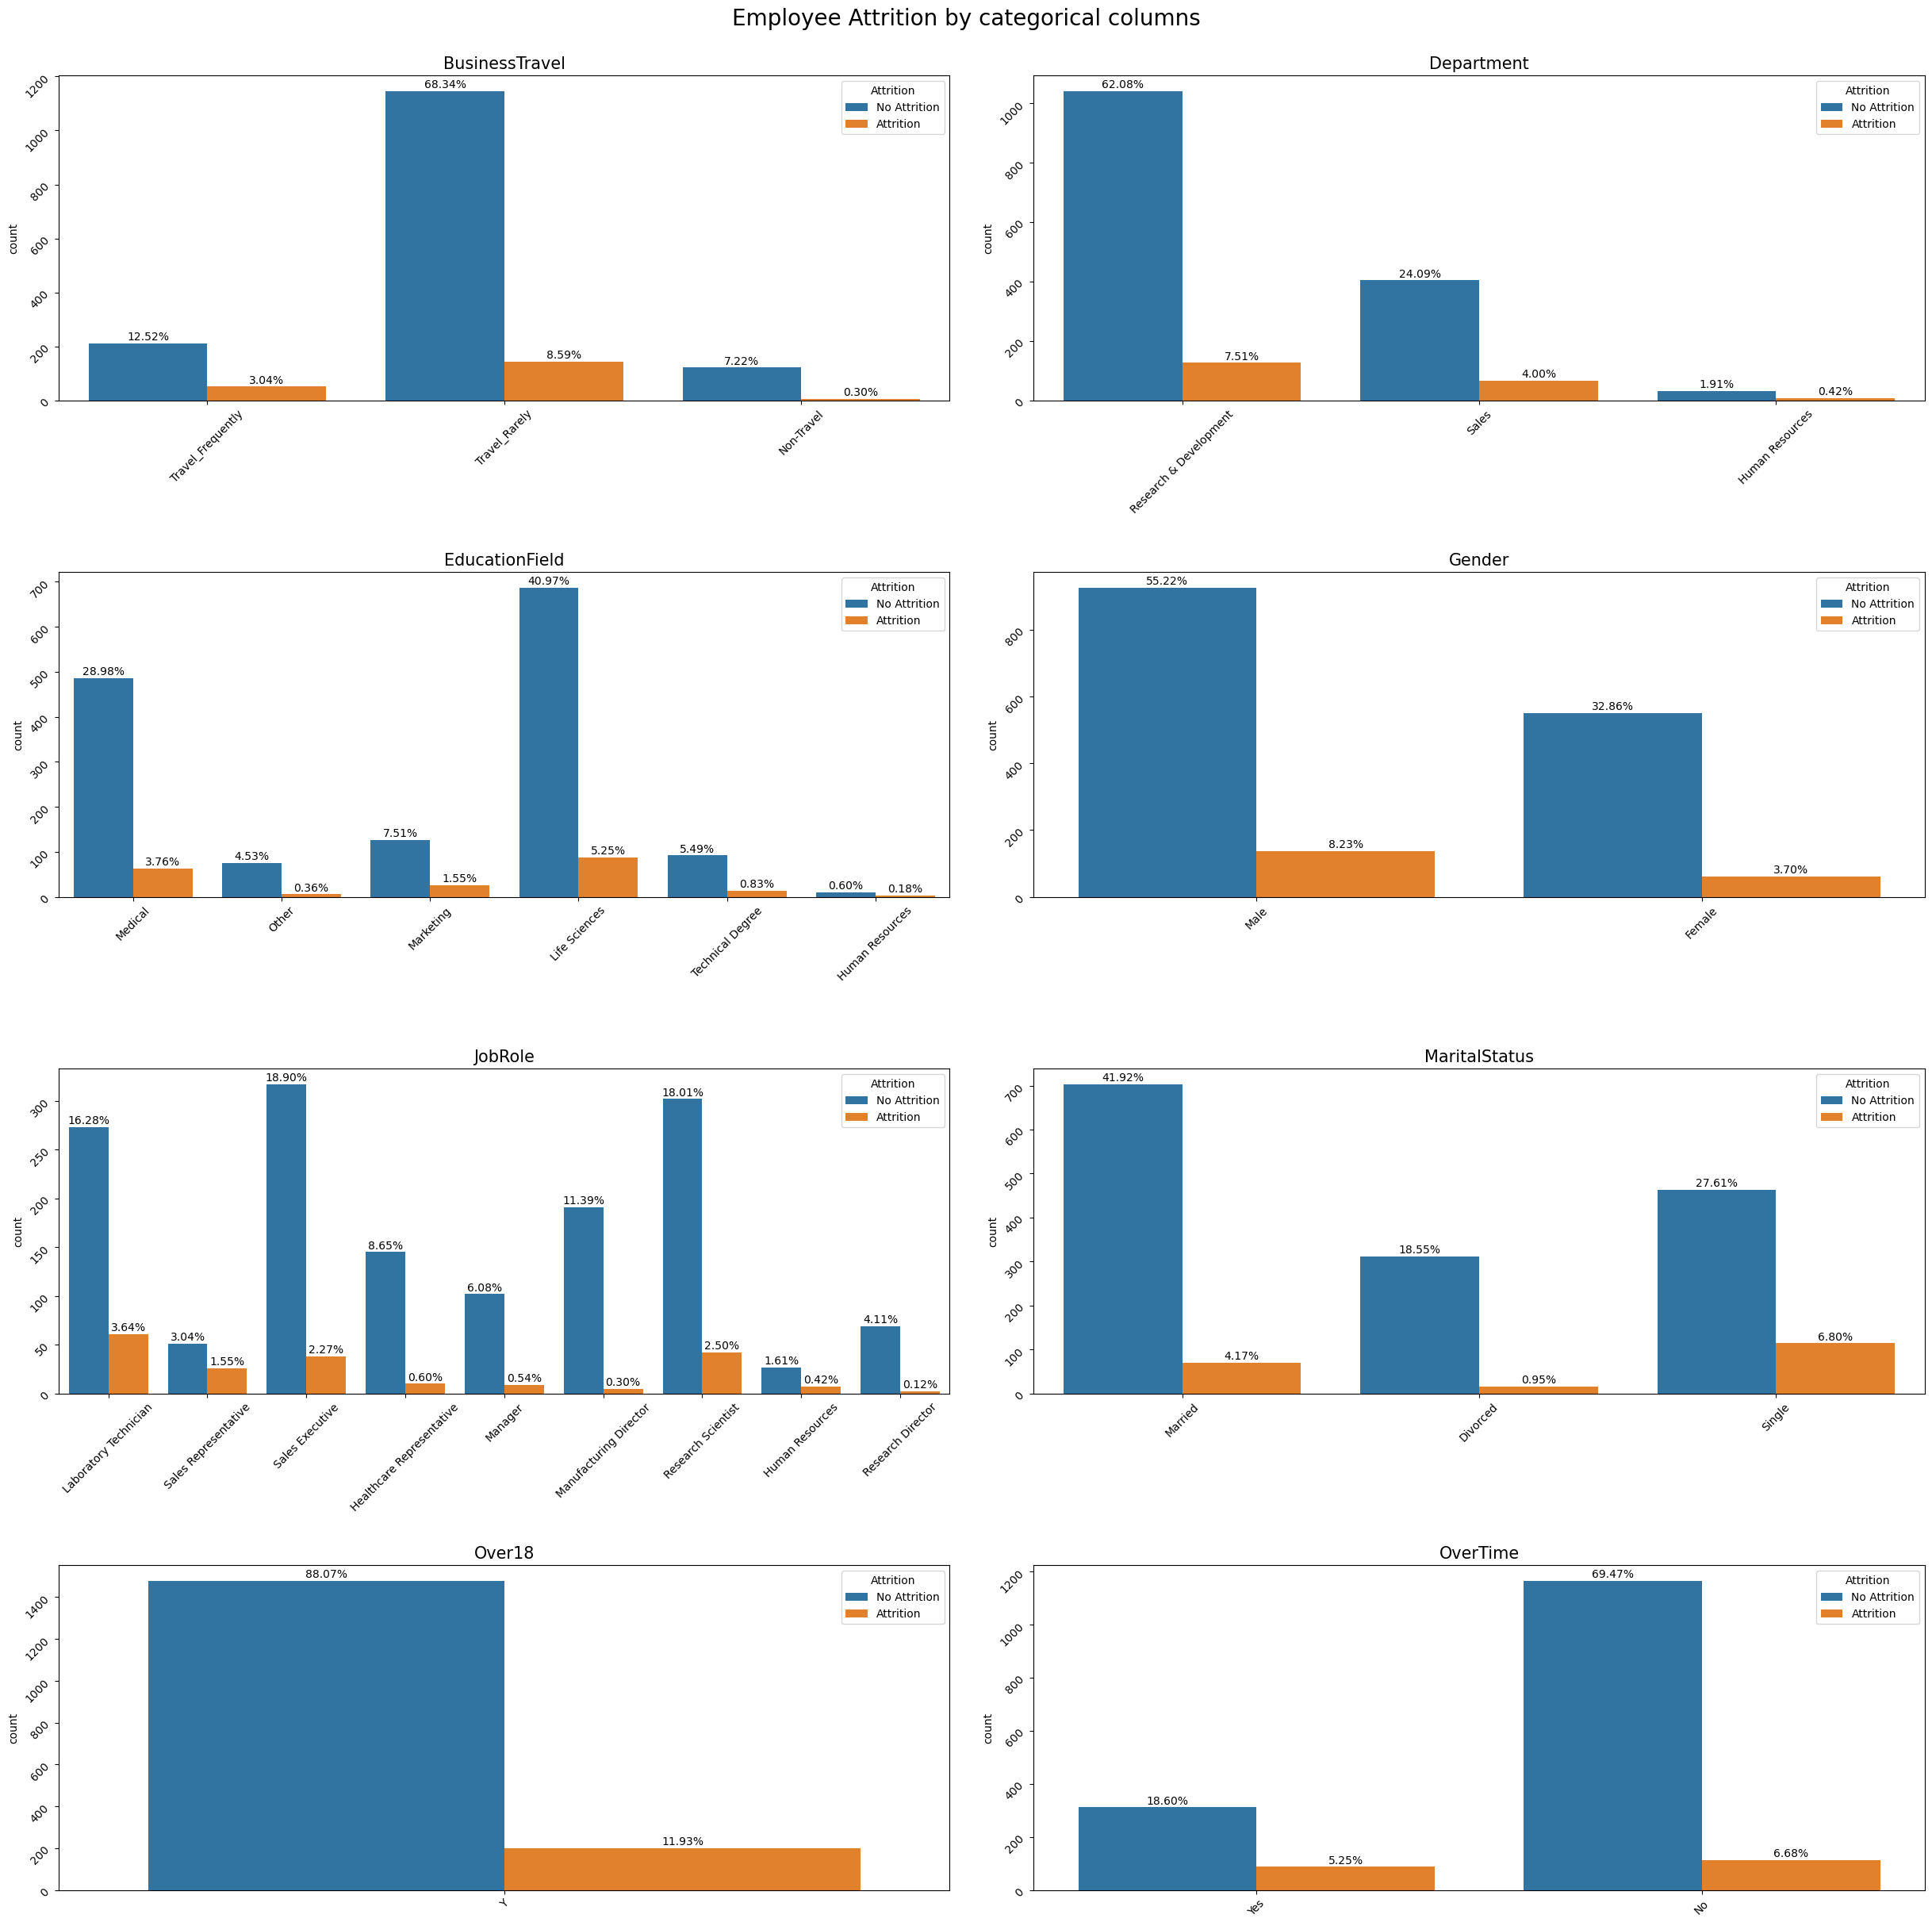

In [16]:
fig , ax = plt.subplots(4,2,figsize=(25,25))
total = len(train)
ax =  np.ravel(ax)

for i , col in enumerate(categorical_feat):
  sns.countplot(ax=ax[i],x=train[col],hue=train['Attrition'])
  ax[i].tick_params(labelrotation=45)
  ax[i].set_title(f"{col}",fontsize=15)
  ax[i].legend(title='Attrition', loc='upper right', labels=['No Attrition', 'Attrition'])
  ax[i].set(xlabel=None)
  
  for p in ax[i].patches:
    percentage = f'{100*p.get_height()/total:.2f}%\n'
    x = p.get_x() + p.get_width()/2
    y = p.get_height()
    ax[i].annotate(percentage, (x,y),ha='center',va='center')


fig.suptitle("Employee Attrition by categorical columns",fontsize = 20)
fig.tight_layout(pad = 3)
plt.show()

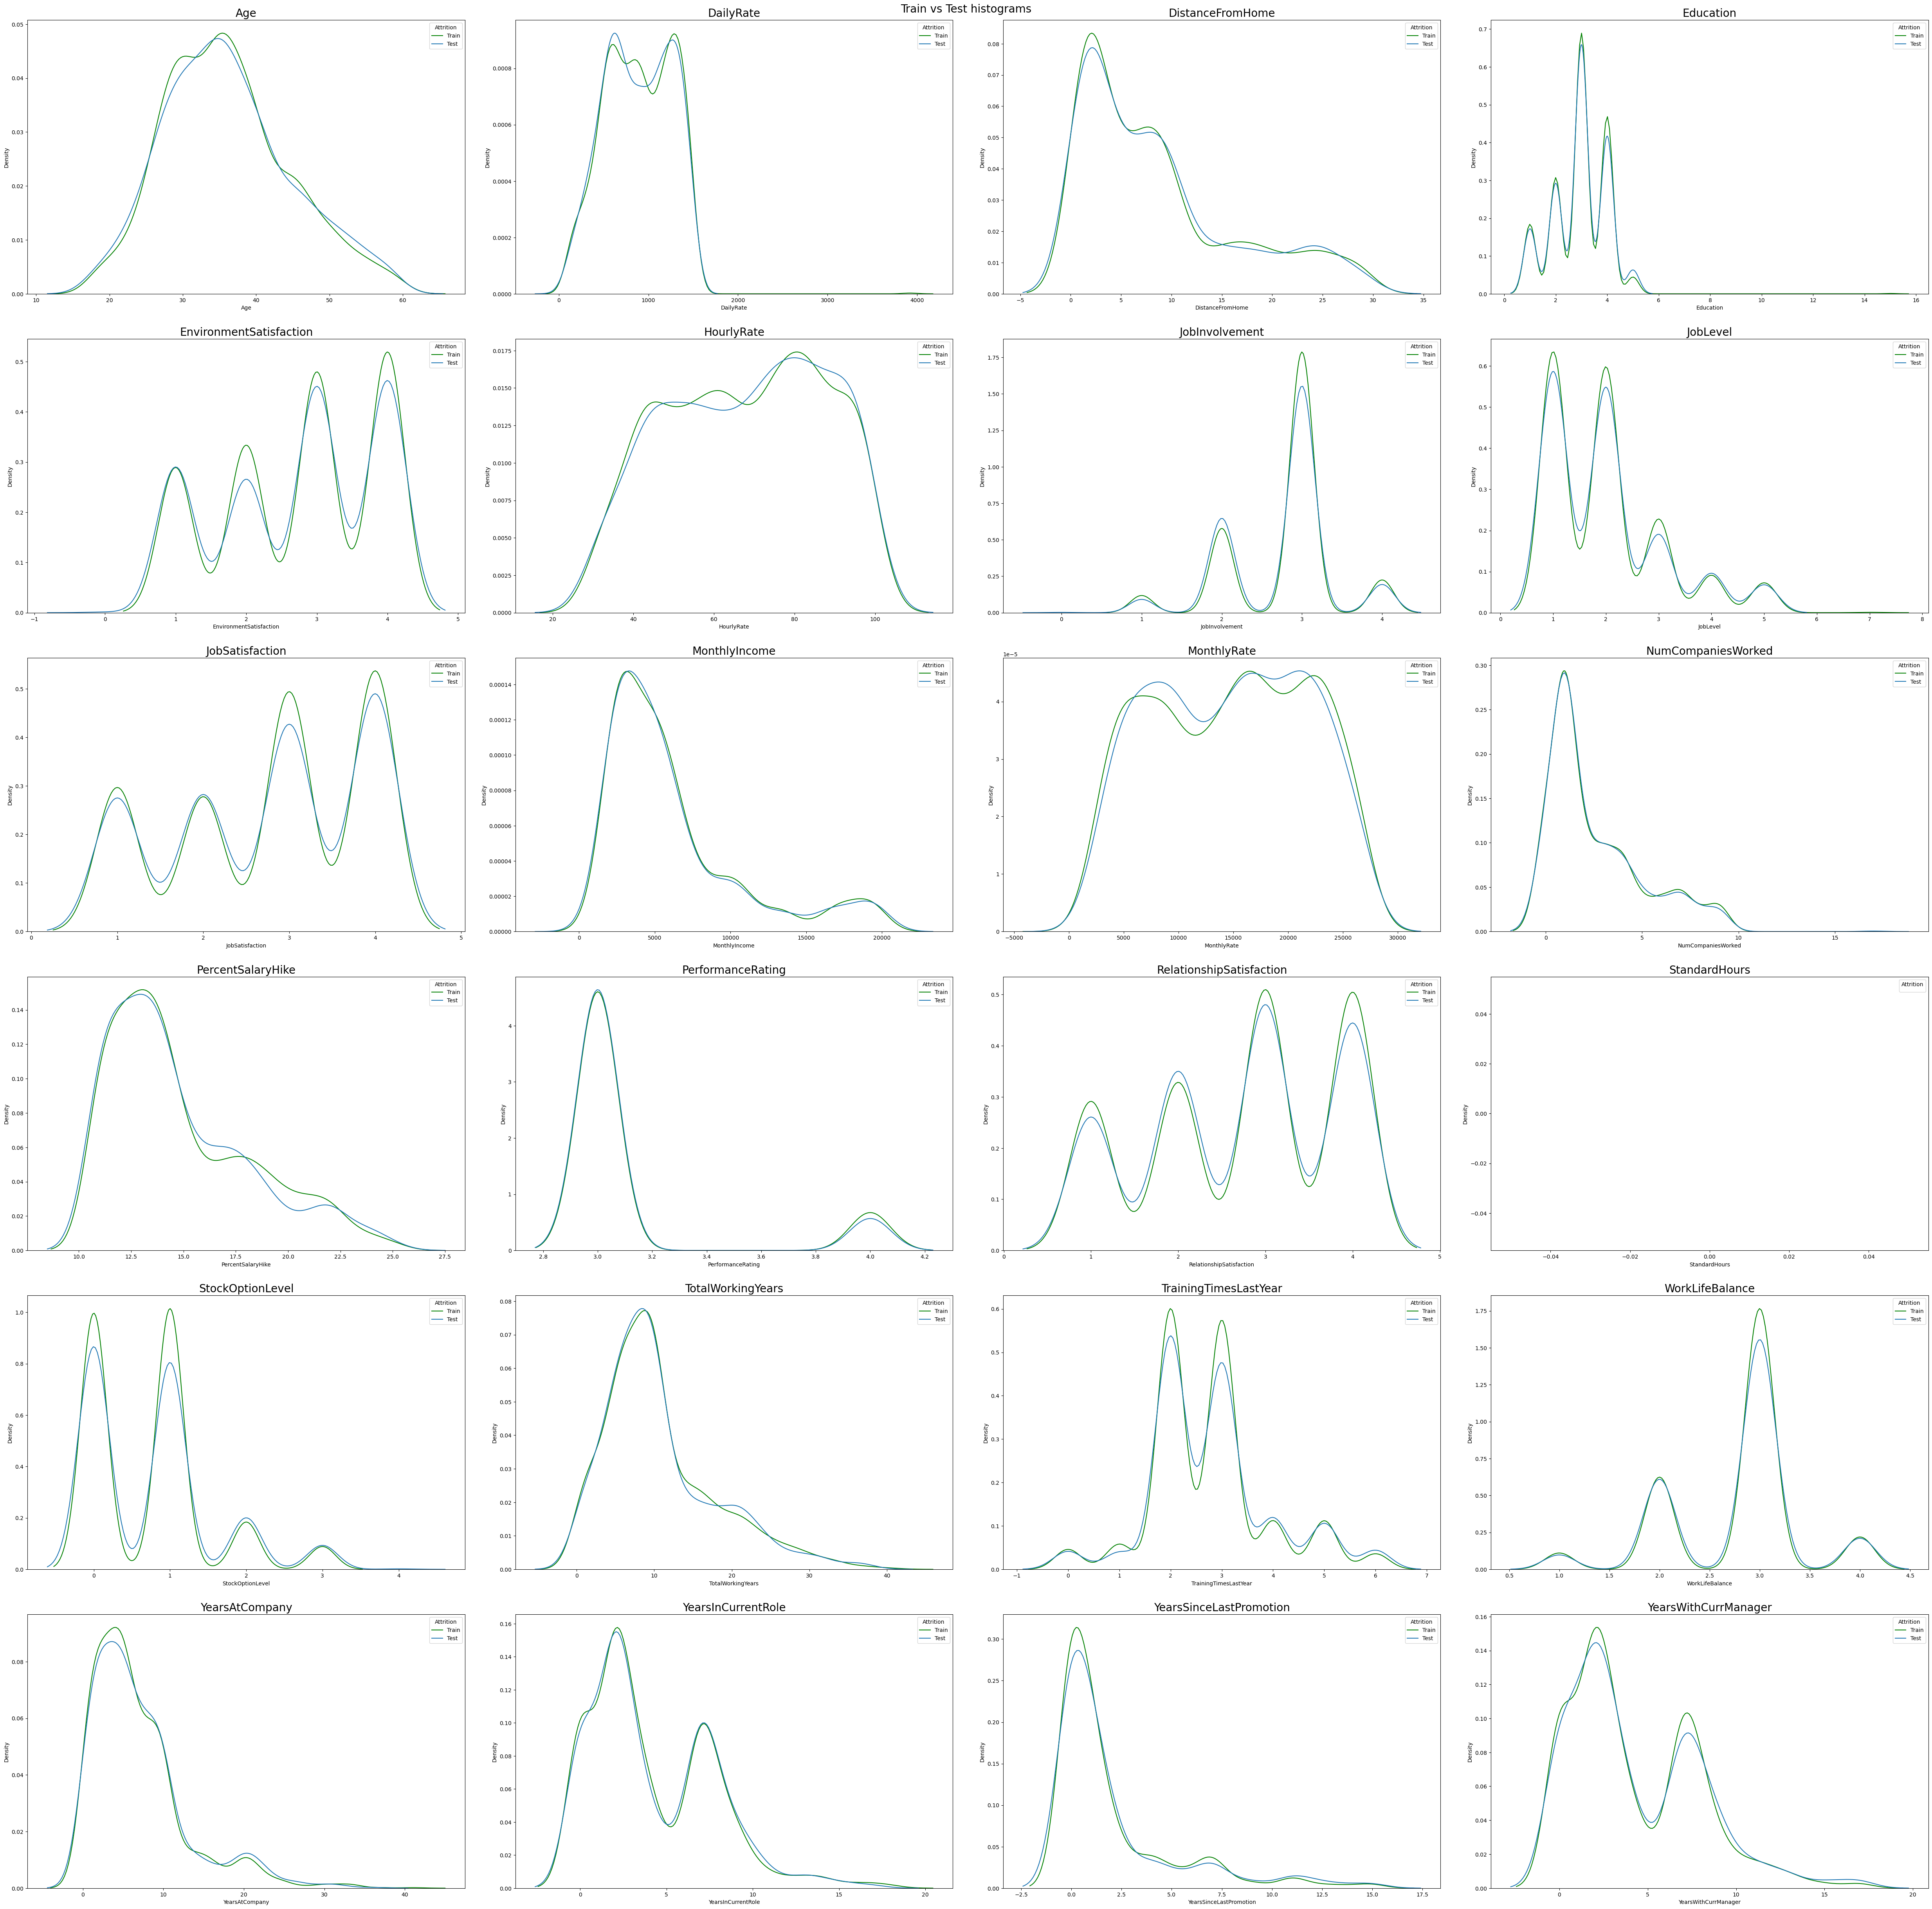

In [17]:
fig,ax = plt.subplots(6,4,figsize = (50,50))
ax = np.ravel(ax)

for i,col in enumerate(numerical_feat):
    sns.kdeplot(ax = ax[i], x = train[col], label = "Train", color= "green",warn_singular=False)
    sns.kdeplot(ax = ax[i], x = test[col], label = "Test",warn_singular=False)
    
    ax[i].set_title(f"{col}",fontsize=20)
#     ax[i].xlabel(fontsize=18)

    ax[i].legend(title='Attrition', loc='upper right', labels=['Train', 'Test'])
    
fig.suptitle("Train vs Test histograms",fontsize = 20)
plt.tight_layout(pad=3)
plt.show()

## Keras: Categorical and Numerical Variables

In [18]:
# reference:
# https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/structured_data/preprocessing_layers.ipynb

In [19]:
# Split the data into train and test sets
X = train.drop(['Attrition', 'Age'], axis=1)
y = train['Attrition']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Assuming X has fewer samples than y
n_samples = len(X)
y = y.iloc[:n_samples]


In [20]:
dataframe = train
train, val, test = np.split(dataframe.sample(frac=1), [int(0.8*len(dataframe)), int(0.9*len(dataframe))])


In [21]:
# List of categorical feature column names
categorical_features = ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'Over18', 'OverTime']

# Create new DataFrame containing only the categorical features
train_categorical = train[categorical_features].copy()
train_categorical.head()

,BusinessTravel,Department,EducationField,Gender,JobRole,MaritalStatus,Over18,OverTime
181,Travel_Rarely,Research & Development,Life Sciences,Male,Research Scientist,Divorced,Y,Yes
154,Travel_Frequently,Research & Development,Life Sciences,Male,Research Scientist,Divorced,Y,No
1166,Travel_Rarely,Sales,Marketing,Male,Sales Executive,Single,Y,No
770,Travel_Rarely,Research & Development,Life Sciences,Male,Research Director,Divorced,Y,No
1356,Travel_Rarely,Research & Development,Other,Female,Laboratory Technician,Married,Y,Yes


In [22]:
print(len(train), 'training examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

1341 training examples
168 validation examples
168 test examples


In [23]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  df = dataframe.copy()
  labels = df.pop('Attrition')
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
  ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

In [24]:
batch_size = 5

In [25]:
train_ds = df_to_dataset(train, batch_size=batch_size)

In [26]:
[(train_features, label_batch)] = train_ds.take(1)
print('Every feature:', list(train_features.keys()))
print('A batch of ages:', train_features['Age'])
print('A batch of targets:', label_batch )

Every feature: ['id', 'Age', 'BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'Attrition']
A batch of ages: tf.Tensor(
[[36]
 [50]
 [31]
 [33]
 [40]], shape=(5, 1), dtype=int64)
A batch of targets: tf.Tensor([0 0 0 1 0], shape=(5,), dtype=int64)


In [27]:
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for the feature.
  normalizer = layers.Normalization(axis=None)

  # Prepare a Dataset that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

In [28]:
count_col = train_features['Attrition']
layer = get_normalization_layer('Attrition', train_ds)
layer(count_col)

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[-0.3719812],
       [-0.3719812],
       [-0.3719812],
       [ 2.6883066],
       [-0.3719812]], dtype=float32)>

In [29]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a layer that turns strings into integer indices.
  if dtype == 'string':
    index = layers.StringLookup(max_tokens=max_tokens)
  # Otherwise, create a layer that turns integer values into integer indices.
  else:
    index = layers.IntegerLookup(max_tokens=max_tokens)

  # Prepare a `tf.data.Dataset` that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Encode the integer indices.
  encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply multi-hot encoding to the indices. The lambda function captures the
  # layer, so you can use them, or include them in the Keras Functional model later.
  return lambda feature: encoder(index(feature))

In [30]:
test_type_col = train_features['Gender']
test_type_layer = get_category_encoding_layer(name='Gender',
                                              dataset=train_ds,
                                              dtype='string')
test_type_layer(test_type_col)

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.]], dtype=float32)>

In [31]:
test_age_col = train_features['Age']
test_age_layer = get_category_encoding_layer(name='Age',
                                             dataset=train_ds,
                                             dtype='int64',
                                             max_tokens=5)
test_age_layer(test_age_col)

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)>

In [32]:
batch_size = 256
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [33]:
all_inputs = []
encoded_features = []

# Numerical features.
for header in ['DailyRate', 'DistanceFromHome']:
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col)

In [34]:
age_col = tf.keras.Input(shape=(1,), name='Age', dtype='int64')

encoding_layer = get_category_encoding_layer(name='Age',
                                             dataset=train_ds,
                                             dtype='int64',
                                             max_tokens=5)
encoded_age_col = encoding_layer(age_col)
all_inputs.append(age_col)
encoded_features.append(encoded_age_col)

In [35]:
categorical_cols = ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'Over18', 'OverTime']


for header in categorical_cols:
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
  encoding_layer = get_category_encoding_layer(name=header,
                                               dataset=train_ds,
                                               dtype='string',
                                               max_tokens=5)
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs.append(categorical_col)
  encoded_features.append(encoded_categorical_col)

In [36]:
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(32, activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(all_inputs, output)

In [37]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])

In [38]:
model.fit(train_ds, epochs=12, validation_data=val_ds)

Epoch 1/12
6/6 [==============================] - 2s 103ms/step - loss: 0.8938 - accuracy: 0.5779 - val_loss: 0.7887 - val_accuracy: 0.7440
Epoch 2/12
6/6 [==============================] - 0s 8ms/step - loss: 0.7905 - accuracy: 0.6801 - val_loss: 0.6878 - val_accuracy: 0.8631
Epoch 3/12
6/6 [==============================] - 0s 8ms/step - loss: 0.7133 - accuracy: 0.7517 - val_loss: 0.6062 - val_accuracy: 0.8810
Epoch 4/12
6/6 [==============================] - 0s 8ms/step - loss: 0.6558 - accuracy: 0.8136 - val_loss: 0.5423 - val_accuracy: 0.8810
Epoch 5/12
6/6 [==============================] - 0s 10ms/step - loss: 0.5778 - accuracy: 0.8494 - val_loss: 0.4924 - val_accuracy: 0.8810
Epoch 6/12
6/6 [==============================] - 0s 9ms/step - loss: 0.5321 - accuracy: 0.8628 - val_loss: 0.4544 - val_accuracy: 0.8810
Epoch 7/12
6/6 [==============================] - 0s 9ms/step - loss: 0.5023 - accuracy: 0.8755 - val_loss: 0.4263 - val_accuracy: 0.8810
Epoch 8/12
6/6 [===============

In [39]:
loss, accuracy = model.evaluate(train_ds)
print("Accuracy", accuracy)

6/6 [==============================] - 0s 7ms/step - loss: 0.3854 - accuracy: 0.8784
Accuracy 0.8784489035606384


## Sequential model

In [41]:
# references
# https://colab.research.google.com/github/tensorflow/docs/blob/snapshot-keras/site/en/guide/keras/sequential_model.ipynb

In [42]:
def find_categorical(df):
    cat = df.dtypes[df.dtypes == 'object'].index
    return cat

cat_cols = find_categorical(train)

In [43]:
 for col in find_categorical(train):
    train = pd.concat([train, pd.get_dummies(train[col], prefix=col)], axis=1)
    train.drop([col], axis=1, inplace=True)


train.head()

,id,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Over18_Y,OverTime_No,OverTime_Yes
181,181,39,571,9,3,1,1,66,3,1,...,0,1,0,0,1,0,0,1,0,1
154,154,26,1211,11,2,1,4,66,1,1,...,0,1,0,0,1,0,0,1,1,0
1166,1166,34,648,20,3,1,4,54,2,2,...,0,0,1,0,0,0,1,1,1,0
770,770,50,898,13,4,1,3,81,3,5,...,1,0,0,0,1,0,0,1,1,0
1356,1356,28,130,2,3,1,2,46,3,1,...,0,0,0,0,0,1,0,1,0,1


In [44]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1341 entries, 181 to 448
Data columns (total 56 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   id                                 1341 non-null   int64
 1   Age                                1341 non-null   int64
 2   DailyRate                          1341 non-null   int64
 3   DistanceFromHome                   1341 non-null   int64
 4   Education                          1341 non-null   int64
 5   EmployeeCount                      1341 non-null   int64
 6   EnvironmentSatisfaction            1341 non-null   int64
 7   HourlyRate                         1341 non-null   int64
 8   JobInvolvement                     1341 non-null   int64
 9   JobLevel                           1341 non-null   int64
 10  JobSatisfaction                    1341 non-null   int64
 11  MonthlyIncome                      1341 non-null   int64
 12  MonthlyRate        

In [45]:

print('Number of samples in X_train:', X_train.shape[0])
print('Number of samples in y_train:', y_train.shape[0])

Number of samples in X_train: 1341
Number of samples in y_train: 1341


In [46]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Define the model
model = Sequential([
    Dense(units=16, activation='relu', input_shape=(train.shape[1],)),
    Dense(units=8, activation='relu'),
    Dense(units=1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define the target variable y_train
y_train = train['Attrition'].values

# Train the model
history = model.fit(train, y_train, epochs=12, batch_size=32, validation_split=0.2)


Epoch 1/12
34/34 [==============================] - 1s 9ms/step - loss: 65.3550 - accuracy: 0.7612 - val_loss: 22.6333 - val_accuracy: 0.8699
Epoch 2/12
34/34 [==============================] - 0s 3ms/step - loss: 30.4202 - accuracy: 0.8144 - val_loss: 18.2382 - val_accuracy: 0.7844
Epoch 3/12
34/34 [==============================] - 0s 3ms/step - loss: 22.7509 - accuracy: 0.8200 - val_loss: 13.1377 - val_accuracy: 0.8364
Epoch 4/12
34/34 [==============================] - 0s 3ms/step - loss: 16.9898 - accuracy: 0.8134 - val_loss: 10.4565 - val_accuracy: 0.7584
Epoch 5/12
34/34 [==============================] - 0s 3ms/step - loss: 11.4488 - accuracy: 0.8078 - val_loss: 6.9045 - val_accuracy: 0.8550
Epoch 6/12
34/34 [==============================] - 0s 3ms/step - loss: 7.8221 - accuracy: 0.8004 - val_loss: 4.0124 - val_accuracy: 0.8476
Epoch 7/12
34/34 [==============================] - 0s 3ms/step - loss: 3.8718 - accuracy: 0.8060 - val_loss: 2.8572 - val_accuracy: 0.6877
Epoch 8/12


In [47]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 16)                912       
                                                                 
 dense_3 (Dense)             (None, 8)                 136       
                                                                 
 dense_4 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1,057
Trainable params: 1,057
Non-trainable params: 0
_________________________________________________________________


## Hyperparameter Tuning

In [48]:
# Reference
# https://colab.research.google.com/github/tensorflow/tensorboard/blob/master/docs/hyperparameter_tuning_with_hparams.ipynb#scrollTo=atWM-s8yVnfX

In [49]:
from tensorboard.plugins.hparams import api as hp

In [50]:
X = train.drop(['Attrition', 'id'], axis=1)
y = train['Attrition']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Assuming X has fewer samples than y
n_samples = len(X)
y = y.iloc[:n_samples]

In [51]:
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([16, 32]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.2))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))

METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS, HP_DROPOUT, HP_OPTIMIZER],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )

In [52]:
def train_test_model(hparams):
  model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(hparams[HP_NUM_UNITS], activation=tf.nn.relu),
    tf.keras.layers.Dropout(hparams[HP_DROPOUT]),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax),
  ])
  model.compile(
      optimizer=hparams[HP_OPTIMIZER],
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy'],
  )

  model.fit(X_train, y_train, epochs=1) # Run with 1 epoch to speed things up for demo purposes
  _, accuracy = model.evaluate(X_test, y_test)
  return accuracy

In [53]:
def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    accuracy = train_test_model(hparams)
    tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

In [54]:
print('Number of samples in X_train:', X_train.shape[0])
print('Number of samples in y_train:', y_train.shape[0])

Number of samples in X_train: 1072
Number of samples in y_train: 1072


In [55]:
session_num = 0

for num_units in HP_NUM_UNITS.domain.values:
  for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
    for optimizer in HP_OPTIMIZER.domain.values:
      hparams = {
          HP_NUM_UNITS: num_units,
          HP_DROPOUT: dropout_rate,
          HP_OPTIMIZER: optimizer,
      }
      run_name = "run-%d" % session_num
      print('--- Starting trial: %s' % run_name)
      print({h.name: hparams[h] for h in hparams})
      run('logs/hparam_tuning/' + run_name, hparams)
      session_num += 1

--- Starting trial: run-0
{'num_units': 16, 'dropout': 0.1, 'optimizer': 'adam'}
9/9 [==============================] - 0s 2ms/step - loss: 607.9761 - accuracy: 0.1970
--- Starting trial: run-1
{'num_units': 16, 'dropout': 0.1, 'optimizer': 'sgd'}
9/9 [==============================] - 0s 2ms/step - loss: 83.1671 - accuracy: 0.8699
--- Starting trial: run-2
{'num_units': 16, 'dropout': 0.2, 'optimizer': 'adam'}
9/9 [==============================] - 0s 2ms/step - loss: 507.5296 - accuracy: 0.8625
--- Starting trial: run-3
{'num_units': 16, 'dropout': 0.2, 'optimizer': 'sgd'}
9/9 [==============================] - 0s 2ms/step - loss: 2.0885 - accuracy: 0.8699
--- Starting trial: run-4
{'num_units': 32, 'dropout': 0.1, 'optimizer': 'adam'}
9/9 [==============================] - 0s 2ms/step - loss: 149.9990 - accuracy: 0.8587
--- Starting trial: run-5
{'num_units': 32, 'dropout': 0.1, 'optimizer': 'sgd'}
9/9 [==============================] - 0s 2ms/step - loss: 2.0855 - accuracy: 0.8699
